# Data Engineering

In [ ]:
pip install ta

In [2]:
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# data = pd.read_csv('/content/senti.csv')
data = pd.read_csv('senti.csv')


data["date"] = pd.to_datetime(data["date"])
data = data.sort_values("date").set_index("date")

features = [
    "transaction amount(CNY)",
    "turnover rate",
    "Stock Index Futures Premiums and Discounts",
    "Implied Risk Premium",
    "Stock-bond yield spread",
    "RSI",
    "Proportion of margin purchases",
    "Market value of restricted shares released",
    "Number of stocks with daily limit",
    "Senti Index"
]
target = ['close(CNY)']
data = data[target + features]

data["transaction amount(CNY)"] = np.log1p(data["transaction amount(CNY)"])
data["Market value of restricted shares released"] = np.log1p(data["Market value of restricted shares released"])

In [4]:
N_LAGS = 4
for lag in range(1, N_LAGS + 1):
  for col in features:
    data[f"{col}_lag{lag}"] = data[col].shift(lag)

data["target"] = np.log(data["close(CNY)"].shift(-3) / data["close(CNY)"])
data["target"] = data["target"].rolling(window=3).mean().shift(-2)
data["target_cls"] = (data["target"] > 0).astype(int)

In [5]:
df_ta = data.copy()

# 1. RSI
df_ta["RSI_14"] = ta.momentum.RSIIndicator(close=df_ta["close(CNY)"], window=14).rsi()

# 2. MACD
macd = ta.trend.MACD(close=df_ta["close(CNY)"])
df_ta["MACD"] = macd.macd()
df_ta["MACD_signal"] = macd.macd_signal()
df_ta["MACD_diff"] = macd.macd_diff()

# 3. Bollinger Bands
bb = ta.volatility.BollingerBands(close=df_ta["close(CNY)"], window=20, window_dev=2)
df_ta["bb_upper"] = bb.bollinger_hband()
df_ta["bb_lower"] = bb.bollinger_lband()
df_ta["bb_width"] = bb.bollinger_wband()

# 4. Moving Averages
df_ta["ma_5"] = df_ta["close(CNY)"].rolling(window=5).mean()
df_ta["ma_10"] = df_ta["close(CNY)"].rolling(window=10).mean()
df_ta["ma_ratio"] = df_ta["ma_5"] / df_ta["ma_10"] - 1

# 5. Volatility (ATR)
df_ta["volatility"] = ta.volatility.AverageTrueRange(
    high=df_ta["close(CNY)"],
    low=df_ta["close(CNY)"],
    close=df_ta["close(CNY)"],
    window=14
).average_true_range()


In [6]:
df_model = data.dropna().copy()
lag_features = [col for col in df_model.columns if any(f in col for f in features) and "lag" in col]
# X = df_model[lag_features]
# y = df_model["target"]

# Data Visualization and Intepretation

In [9]:
import pandas as pd

df = pd.read_csv("senti.csv")

df

,date,close(CNY),transaction amount(CNY),turnover rate,Stock Index Futures Premiums and Discounts,Implied Risk Premium,Stock-bond yield spread,RSI,IPO Funds Raised,Proportion of margin purchases,Total transaction volume of Mainland-Hong Kong Stock Connect,Market value of restricted shares released,Number of stocks with daily limit,Number of new fund accounts opened,Original Senti Index,Senti Index
0,2015-01-06,4338.9340,809027862528,2.2172,0.432319,0.019519,0.505397,100.000000,3.515760,0.167407,94.6932,304869.3251,45.0,68.86,0.471386,0.490939
1,2015-01-07,4341.8940,655086510080,1.7380,0.532687,0.019324,0.500000,100.000000,3.515760,0.171045,94.6932,304869.3251,23.0,68.86,0.426842,0.467973
2,2015-01-08,4277.7610,611211096064,1.6582,0.077010,0.020504,0.494872,32.728093,3.515760,0.164724,94.6932,304869.3251,31.0,68.86,0.191841,0.346810
3,2015-01-09,4257.0590,674590175232,1.7736,-0.527896,0.020508,0.506420,26.889069,3.515760,0.172792,94.6932,304869.3251,10.0,68.86,0.198532,0.350260
4,2015-01-12,4209.3830,547138437120,1.4291,0.683748,0.021301,0.494958,19.058469,3.515760,0.170317,94.6932,415864.6745,23.0,68.86,0.123850,0.311755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,2024-08-12,3875.2827,485139502964,0.8309,-0.001939,0.043458,-0.213147,42.408143,15.014526,0.071148,795.8219,149058.1084,28.0,13.41,-0.431019,0.025674
2336,2024-08-13,3890.6632,467990450742,0.7736,-0.131667,0.043291,-0.205736,48.836204,15.014526,0.077415,845.4333,149058.1084,37.0,13.41,-0.406777,0.038172
2337,2024-08-14,3858.5330,467261108147,0.7560,-0.152268,0.044230,-0.204712,46.141683,15.014526,0.076753,759.8942,149058.1084,31.0,13.41,-0.426823,0.027837
2338,2024-08-15,3894.4067,580072719381,0.9698,-0.064423,0.043613,-0.202823,46.058933,6.000000,0.078042,1011.2054,149058.1084,47.0,13.41,-0.394973,0.044258


In [10]:
df['date'].value_counts()

,count
date,
2024-08-16,1
2015-01-06,1
2015-01-07,1
2015-01-08,1
2024-07-25,1
...,...
2015-01-16,1
2015-01-15,1
2015-01-14,1


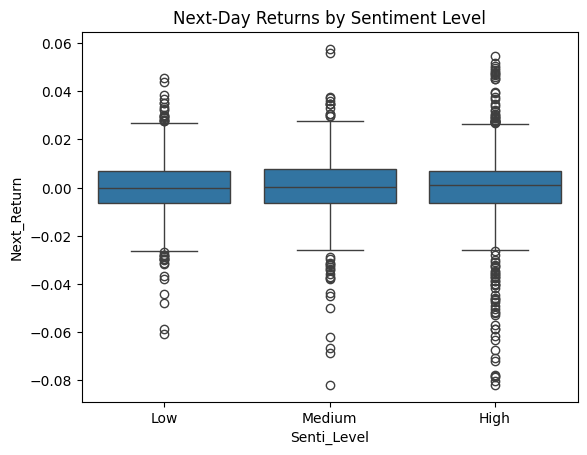

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


df_1 = df.copy()

df_1["Senti_Level"] = pd.qcut(df_1["Senti Index"], q=3, labels=["Low", "Medium", "High"])

## Count the next day's return rate for each sentiment interval
df_1["Next_Return"] = df_1["close(CNY)"].pct_change().shift(-1)
sns.boxplot(x="Senti_Level", y="Next_Return", data=df_1)
plt.title("Next-Day Returns by Sentiment Level")
plt.show()

## Close Price Trend Graph

The line graph, titled "Close Price Trend," visually represents the fluctuations in the closing prices of a stock denominated in CNY over a time period. The plot is instrumental in analyzing the stock's performance and identifying trends.

## Key Observations from the Graph

### Initial Peak
- **Description**: The graph shows a sharp peak early in the series where the prices rise dramatically and then fall equally sharply.
- **Interpretation**: This suggests a volatile period for the stock. Such spikes may be driven by external market events, news, or changes in investor sentiment, which attract a lot of buying followed by quick selling.

### Mid-Section Stability and Rise
- **Description**: After the initial sharp movements, the price appears to stabilize and subsequently begins a gradual ascent, peaking again around the middle of the time series.
- **Interpretation**: This phase of stability followed by growth could indicate a period of positive market conditions or effective company performance that gains investor confidence gradually over time.

### Subsequent Decline
- **Description**: Following the mid-section peak, there is a general downward trend in the closing prices toward the end of the series.
- **Interpretation**: This declining trend might reflect worsening market conditions, investor sentiment turning negative, or possibly company-specific issues that could be influencing stock prices negatively.

## Conclusion

The "Close Price Trend" graph provides essential insights into the periods of high volatility, growth, and decline in the stock's price. Understanding these trends is crucial for making informed financial decisions and strategizing investments based on historical performance and future potential.


## Box Plot: Next-Day Returns by Sentiment Level

The box plot titled "Next-Day Returns by Sentiment Level" categorizes stock returns into three sentiment levels: Low, Medium, and High. These categories are derived from the quantiles of the `Senti_Index`. The plot provides a visual comparison of the distribution of returns for each sentiment level, allowing us to infer the impact of sentiment on next-day stock returns.

## Key Observations from the Plot:

### 1. **Median of Each Category**:
- The line inside each box represents the median return for that sentiment level.
- Medians are close to zero across all categories, suggesting that median returns do not drastically differ by sentiment level. However, the High sentiment category slightly outperforms others in terms of median returns.

### 2. **Interquartile Range (IQR)**:
- The length of each box, which shows the middle 50% of the data (from the 25th to the 75th percentile).
- IQRs are similar across all sentiment levels, indicating a consistent variability in returns irrespective of sentiment.

### 3. **Whiskers**:
- The whiskers extend from the boxes to show the range for the majority of the remaining data.
- These do not indicate the maximum and minimum values but typically extend to 1.5 times the IQR from the box edges.

### 4. **Outliers**:
- Individual points outside the whiskers represent outliers, which are returns that lie beyond 1.5 times the IQR.
- Notably, there are numerous outliers in all categories, particularly in the High sentiment level, suggesting more frequent extreme returns when sentiment is higher.

## Conclusion:

The visualization indicates that while the central tendencies (medians) and variabilities (IQRs) of returns are relatively stable across sentiment levels, the sentiment level may influence the occurrence of outliers, particularly positive ones. The High sentiment level displays a slightly higher median return and a notable presence of outliers, suggesting that positive sentiment could correlate with higher and more volatile returns.



# Neural Network

## Model

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0830 - val_loss: 0.0027
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0039 - val_loss: 7.3546e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0021 - val_loss: 4.1841e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 4.1983e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012 - val_loss: 4.2426e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 2.5897e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.8636e-04 - val_loss: 2.4453e-04
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.5892e-04 - val_loss: 2.4576e-04
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.8919e-04 - val_loss: 2.4989e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.1623e-04 - val_loss: 4.1358e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.3730e-04 - val_loss: 2.3630e-04
Epoch 12/50
58

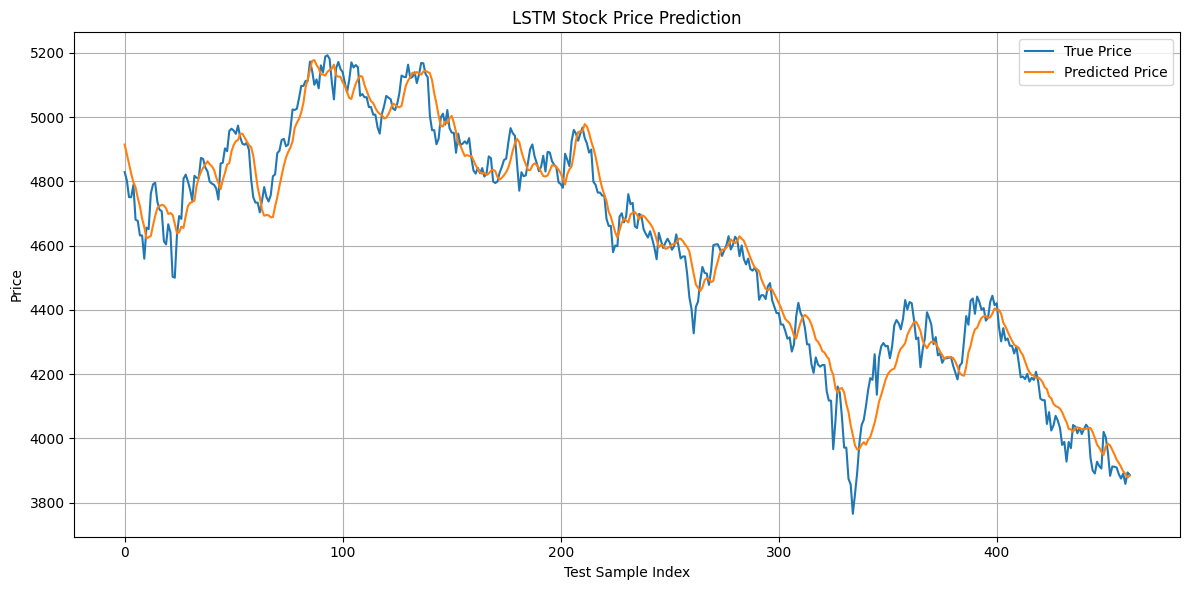

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


features = df[["close_cleaned", "Senti Index", "turnover rate"]]
target = df["close_cleaned"].values.reshape(-1, 1)


scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)


def create_dataset(features, target, n_steps=30):
    X, y = [], []
    for i in range(len(features) - n_steps):
        X.append(features[i:i+n_steps])
        y.append(target[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 30
X_3d, y_target = create_dataset(features_scaled, target_scaled, n_steps)

train_size = int(len(X_3d) * 0.8)
X_train, X_test = X_3d[:train_size], X_3d[train_size:]
y_train, y_test = y_target[:train_size], y_target[train_size:]

n_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

y_pred_scaled = model.predict(X_test)
y_pred = scaler_target.inverse_transform(y_pred_scaled)
y_true = scaler_target.inverse_transform(y_test)

r2 = r2_score(y_true, y_pred)
print(f"R² = {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_true, label="True Price")
plt.plot(y_pred, label="Predicted Price")
plt.title("LSTM Stock Price Prediction")
plt.xlabel("Test Sample Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**LSTM Stock Price Prediction — Visualization Analysis**

The above plot presents a comparison between the true stock prices (blue line) and the predicted prices generated by the LSTM model (orange line) over the testing period.

**- General Trend Tracking**

The LSTM model successfully captures the overall trend direction of the stock price, including both upward and downward movements.

For instance, in the early part of the time series (index ~0–100), the model tracks both local dips and rallies with relatively high fidelity.

During major declines (e.g., index ~250–300 and again ~400–470), the model continues to follow the downward trend, indicating that it has learned some temporal dynamics from past sequences.

**- Smoothing and Lag Effects**

The orange prediction line appears smoother than the actual price, which is common with LSTM models due to their tendency to regularize noise.

However, this smoothing effect leads to a lag in reaction time. For example, sharp inflection points in the true series are often followed by delayed responses in the predictions.

This behavior suggests that the model is better at predicting average movements than at responding to sudden market shocks.

**- Local Accuracy**

In many local regions (e.g., index ~120–180 and 320–360), the predicted line closely hugs the true price curve, which demonstrates the model's ability to recognize short-term patterns.

Despite some minor deviations, the predicted price rarely diverges drastically, maintaining a consistent distance from the true series.

**- Implications**

From a forecasting perspective, this level of alignment suggests strong short-term predictive power, especially when the market follows clear momentum patterns.

However, the lag and smoothing issues imply that the model may not be immediately suitable for high-frequency trading or precise turning-point detection without further refinement or post-processing.

## Model Accuracy

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# === 常用评估指标 ===
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# === 打印结果 ===
print(f"R² Score:        {r2:.4f}")
print(f"MAE:             {mae:.2f}")
print(f"MSE:             {mse:.2f}")
print(f"RMSE:            {rmse:.2f}")
print(f"MAPE:            {mape:.2f}%")

R² Score:        0.9640
MAE:             53.12
MSE:             4648.30
RMSE:            68.18
MAPE:            1.18%


## Residual Analysis

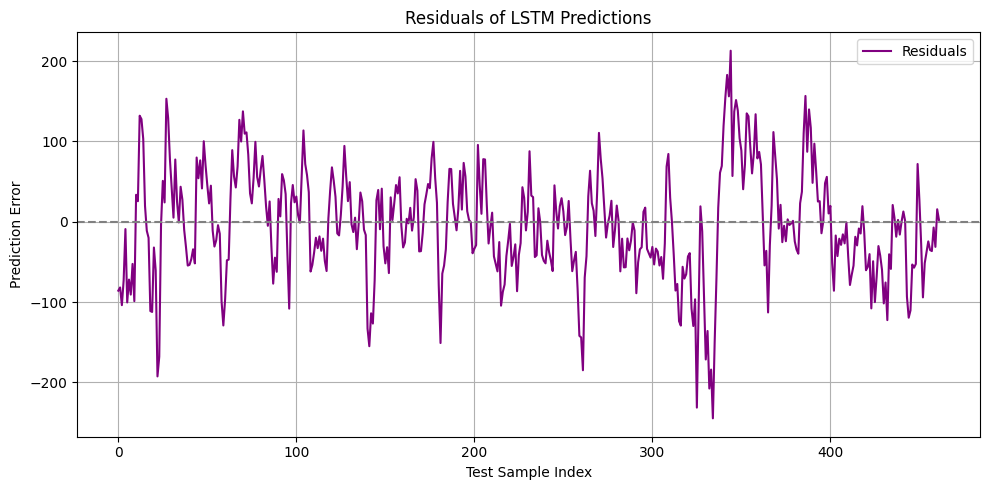

In [32]:
import matplotlib.pyplot as plt

residuals = (y_true - y_pred).flatten()

plt.figure(figsize=(10, 5))
plt.plot(residuals, label="Residuals", color="purple")
plt.axhline(0, linestyle="--", color="gray")
plt.title("Residuals of LSTM Predictions")
plt.xlabel("Test Sample Index")
plt.ylabel("Prediction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Residual Plot — Error Analysis of LSTM Predictions**

The above plot displays the residuals, or prediction errors, of the LSTM model over the testing period. Residuals are calculated as:

$$
\text{Residual}_t = \text{True Price}_t - \text{Predicted Price}_t
$$

**- Key Observations Centered Around Zero**


The majority of residuals fluctuate around the horizontal zero line, suggesting that the model is generally unbiased and does not consistently over- or under-predict stock prices across the entire test period.

**- Volatility Clusters in Specific Regions**

Between index ~0–100 and ~300–400, we observe noticeable bursts of high-magnitude errors, where residuals exceed ±150 units.

This pattern suggests the model may struggle to adapt to periods of high volatility or sudden market changes.

**- Tapering Behavior in Later Segments**

In the latter part of the plot (after index ~400), residual variance appears to narrow, indicating more stable or better-fitted predictions toward the end of the test period.

This could result from the model learning more consistent patterns or simply facing a less volatile market phase.

**- No Strong Serial Correlation**

There is no clear autocorrelated structure in the error series (i.e., errors do not systematically trend up or down), which supports the idea that the model is not systematically missing time-based dependencies.

**- Interpretation & Implications**

Outlier errors above ±200 indicate that the LSTM model occasionally fails to predict major price reversals or abrupt market movements.

While the model performs well in stable conditions, it may benefit from enhancements such as incorporating volatility indicators, regime detection, or attention mechanisms to better handle extreme fluctuations.

This plot complements the high R² score by revealing where and how much the model fails, providing actionable insight for model refinement.

## Scatter plot

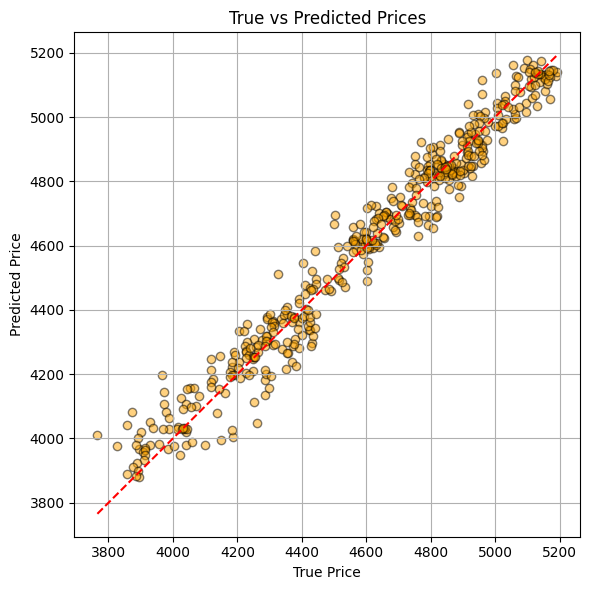

In [33]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5, color="orange", edgecolor="k")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # y=x 参考线
plt.title("True vs Predicted Prices")
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()


**True vs Predicted Prices — Scatter Plot Analysis**

The above scatter plot presents a point-wise comparison between the true stock prices (x-axis) and the LSTM-predicted prices (y-axis) for each test sample. Each dot represents one prediction instance.

**- Model Fit Evaluation Strong Linear Relationship**

The majority of points are tightly clustered around the red dashed line, which represents the ideal case where Predicted Price = True Price.

This indicates that the LSTM model achieves high overall prediction accuracy and captures the level and direction of price movements very well.

**1. Minimal Systematic Bias**

There is no significant deviation above or below the reference line across the range of values, which implies the model does not consistently overestimate or underestimate prices.

The spread of points is symmetric along the diagonal, supporting the conclusion of unbiasedness.

**2. Higher Density Around Central Price Ranges**

Between ~4200 and ~5000 on the x-axis, we observe a dense concentration of points, indicating that the model handles the most common price range with particularly high precision.

In more extreme ranges (especially below 4000), there's slightly more variation, suggesting increased uncertainty in low-price regimes.

**3. Outliers Are Sparse and Mild**

A few points deviate further from the diagonal line, but these are relatively few and not strongly influential.

These outliers may correspond to periods of high volatility or sharp reversals, which are known challenges for LSTM models due to their tendency to smooth short-term fluctuations.

**- Implication for Predictive Performance**
The scatter plot complements quantitative metrics like R² (0.9640) by visually validating the model’s fit.

It reinforces that the LSTM architecture is highly effective at learning the complex, nonlinear dependencies in the data.

From a practical standpoint, this level of accuracy is valuable for applications that depend on short-term price forecasts, such as risk management or price trajectory classification.

# Time Series Models

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
granger_test = grangercausalitytests(df[["close_cleaned", "Senti Index"]], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1026  , p=0.0026  , df_denom=2336, df_num=1
ssr based chi2 test:   chi2=9.1143  , p=0.0025  , df=1
likelihood ratio test: chi2=9.0966  , p=0.0026  , df=1
parameter F test:         F=9.1026  , p=0.0026  , df_denom=2336, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=32.3215 , p=0.0000  , df_denom=2333, df_num=2
ssr based chi2 test:   chi2=64.7815 , p=0.0000  , df=2
likelihood ratio test: chi2=63.9002 , p=0.0000  , df=2
parameter F test:         F=32.3215 , p=0.0000  , df_denom=2333, df_num=2


## Close_cleaned vs trend, seasonal, resid.

This is typically done to better understand different influences on the data and to possibly improve forecasting models by handling these components separately.

### Breakdown of the Decomposition

1. **Top Panel - Original Data (close_cleaned)**:
   - This panel displays the original time series data of the wrangled(after cleaning the data) closing stock prices. It shows how the stock prices have changed over time.

2. **Second Panel - Trend**:
   - The trend component represents the long-term progression of the series, smoothing out short-term fluctuations and seasonal variations. In your graph, the trend shows a general decline after an initial peak, suggesting a downward movement in stock prices over the observed period.

3. **Third Panel - Seasonal**:
   - This component captures the regular pattern of variability within the time series data. The seasonality shown here might represent periodic fluctuations that repeat over a specific interval, which, given a `period=365`, indicates yearly seasonal effects.

4. **Bottom Panel - Residual**:
   - The residuals represent the component of the data that cannot be explained by the trend or seasonal effects. These are essentially the irregularities or random variation left after accounting for the trend and seasonal components. The plot shows these residuals fluctuating around zero, which is typical.

### Interpretation

- **Trend Analysis**:
  - The trend component is crucial for understanding the long-term direction of the stock prices, which appears to be declining after an initial rise. This information can be vital for strategic financial planning and investment decisions.

- **Seasonality Analysis**:
  - Identifying and understanding seasonal patterns can help in predicting peaks and troughs in the stock price throughout the year. This can be particularly useful for seasonal adjustment of forecasts and trading strategies.

- **Residuals Analysis**:
  - Analyzing residuals can help in checking the model's fit to the data. A good fit of the model to the time series would typically show residuals that have no pattern (i.e., noise-like).

### Conclusion

Decomposition is a powerful tool for understanding the behavior of time series data, such as stock prices. It helps in distinguishing the underlying pattern in data from the random noise, thereby improving the accuracy and effectiveness of predictive models used in financial markets. This analysis can be particularly useful for traders, analysts, and portfolio managers engaged in technical analysis or algorithmic trading.


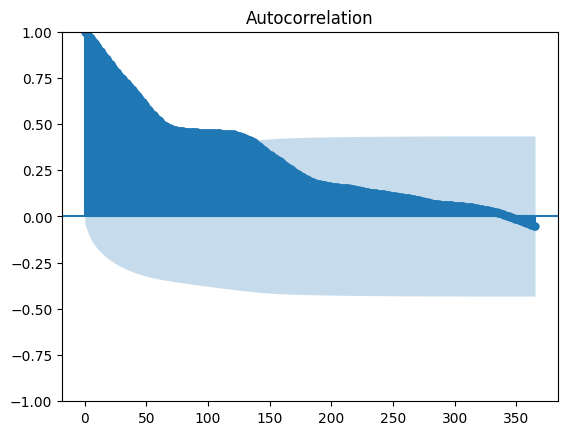

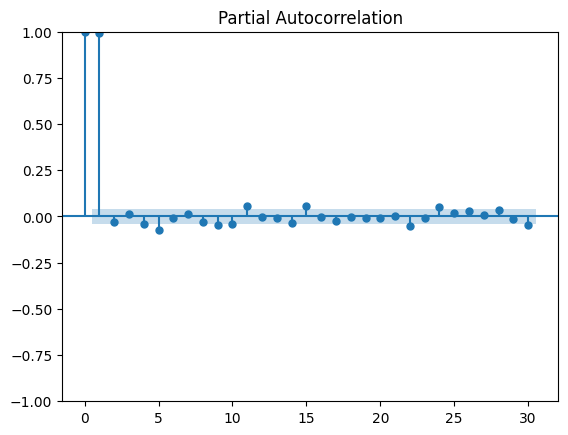

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['close_cleaned'], lags=365)
plt.show()

plot_pacf(df['close_cleaned'], lags=30)
plt.show()

## Autocorrelation Function (ACF)

### Observations:
- The autocorrelation function starts at 1 at lag zero, as expected, since each term is perfectly correlated with itself.
- The ACF exhibits a gradual decline as the lag increases, which typically indicates a non-stationary time series where past values have long-lasting effects on future values.
- The autocorrelation remains within the significance bounds (blue shaded area), suggesting statistically significant autocorrelation at many lags, which could indicate a need for differencing to achieve stationarity.

## Partial Autocorrelation Function (PACF)

### Observations:
- The PACF shows a significant spike at lag 1 and quickly drops to near zero at higher lags. This pattern is indicative of an autoregressive process of order 1, or AR(1).
- Beyond lag 1, the PACF values hover around zero and remain within the significance bounds, confirming that no higher-order AR terms are necessary.

## Implications for Time Series Modeling

### AR(1) Model Suggestion:
- The PACF's sharp cut-off after lag 1 supports modeling the time series with an AR(1) model. This is because in an AR(1) model, the current value is regressed on only its immediate previous value, consistent with the observed PACF.

### Stationarity and Differencing:
- The slow decay in the ACF suggests that the series may benefit from differencing to make it stationary, a prerequisite for many time series forecasting methods to ensure consistent, unbiased parameter estimates.


In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[["transaction amount(CNY)", "turnover rate"]])

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


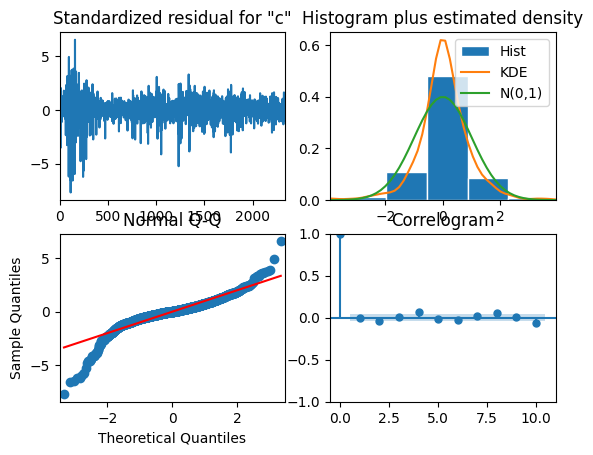

In [25]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df["close_cleaned"], order=(2,1,2))
results = model.fit()
results.plot_diagnostics()  #Check if the residual is white noise
plt.show() # added to display only one graph

## Close_cleaned vs date
The provided graph is generated using Facebook's Prophet, a tool for forecasting time series data. It shows both historical data and future predictions for the closing prices of a stock, denominated in CNY.

### Analysis of the Graph

1. **Data Representation**:
   - The black dots represent the actual historical data points of the stock's closing prices.
   - The blue line indicates the forecasted trend, which Prophet has modeled based on the historical data.

2. **Forecast Components**:
   - The light blue shaded area represents the uncertainty intervals of the forecasts. This area shows the range within which future data points are expected to fall, with a certain probability.

3. **Trend Analysis**:
   - The historical data exhibits a significant peak around the year 2016, followed by a sharp decline. After this decline, the prices show some recovery and fluctuations through the years.
   - Post-2020, the forecasted trend suggests a gradual downward trajectory for the stock prices through 2026. This declining trend might be informed by recent data patterns or underlying seasonal or cyclical trends identified by the model.

### Statistical Insights

- **Stationarity**: The model's ability to capture the sharp peak and subsequent decline indicates that it has effectively handled any non-stationarity in the time series.
- **Seasonality and Holiday Effects**: Prophet automatically detects and accounts for seasonality if present. While not explicitly shown here, the forecast's fluctuations might implicitly factor in these elements based on historical patterns.
- **Model Confidence**: The widening confidence intervals as the forecast extends into the future reflect increasing uncertainty in the predictions. This is typical in time series forecasting, as the ability to predict future values diminishes the further out one goes.

### Conclusion

This forecast provides a useful visualization for understanding potential future trends in stock prices based on historical data. The declining trend in the forecast could be a point of concern for investors or analysts and might prompt further investigation into underlying causes or factors that could be influencing this prediction. Such forecasts are essential for planning and decision-making in financial contexts.


In [26]:
#VAR
from statsmodels.tsa.api import VAR

model_var = VAR(df[["close_cleaned", "Senti Index", "turnover rate"]])
results_var = model_var.fit(maxlags=2)
results_var.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, May, 2025
Time:                     04:07:24
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.45201
Nobs:                     2338.00    HQIC:                  -3.48488
Log likelihood:          -5835.59    FPE:                  0.0300853
AIC:                     -3.50372    Det(Omega_mle):       0.0298167
--------------------------------------------------------------------
Results for equation close_cleaned
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   36.804230        11.750631            3.132           0.002
L1.close_cleaned         0.887764         0.025036           35.460           0.000
L1.Senti Index         842.928200       

In [27]:
from sklearn.metrics import r2_score

actual = df[["close_cleaned", "Senti Index", "turnover rate"]].iloc[results_var.k_ar:]
predicted = results_var.fittedvalues


variables = ["close_cleaned", "Senti Index", "turnover rate"]
r_squared = {}
for var in variables:
    r_squared[var] = r2_score(actual[var], predicted[var])


for var, r2 in r_squared.items():
    print(f"{var} R² = {r2:.4f}")

close_cleaned R² = 0.9886
Senti Index R² = 0.9790
turnover rate R² = 0.8838


At these lags, the Senti Index has predictive information about future changes in close_cleaned (Granger causality)

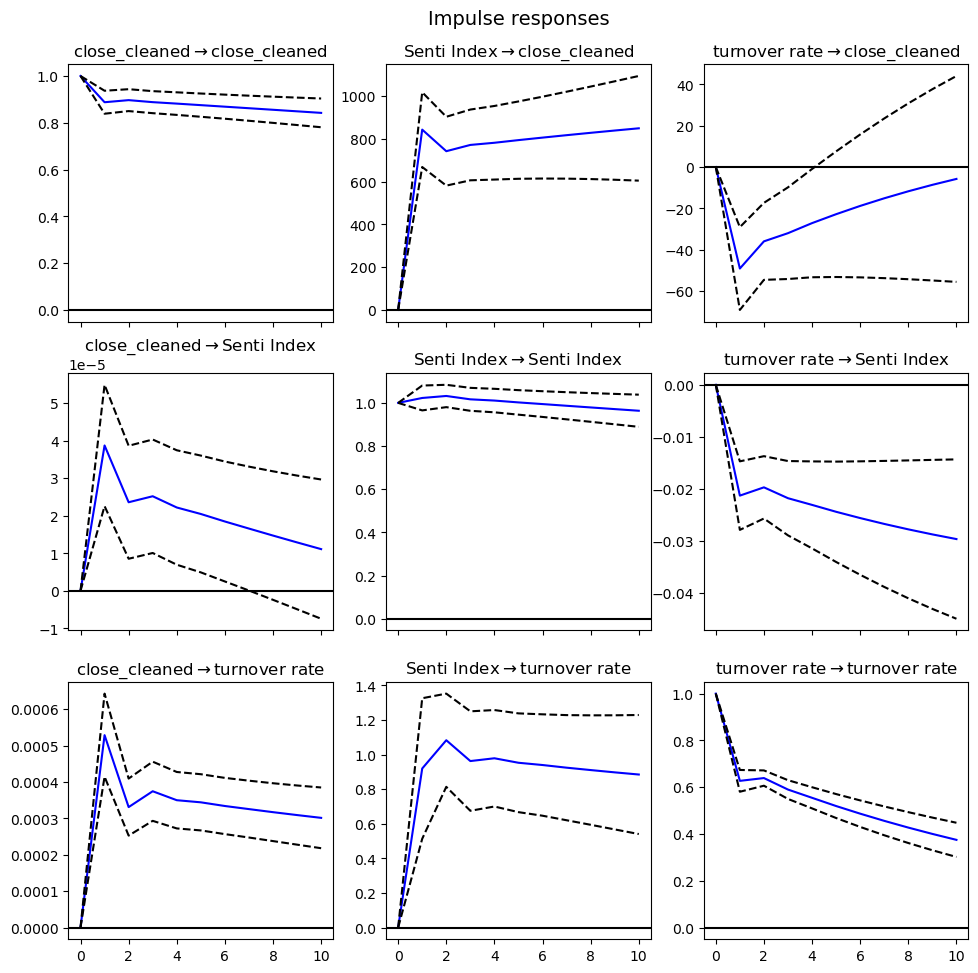

In [ ]:
irf = results_var.irf(periods=10)
irf.plot(orth=False)
plt.show() # added to display only one grpah

The image provided shows a series of impulse response functions (IRFs) from a vector autoregression (VAR) model, illustrating how changes in one variable impact other variables in the system over time. These graphs are valuable for understanding the dynamic interactions between multiple time series variables, such as stock prices, sentiment indices, and turnover rates.

## Explanation of Each Impulse Response Plot:

#### close_cleaned → close_cleaned:
- **Observation**: The response of close_cleaned to its own shock starts at 1 and declines gradually, staying positive.
- **Interpretation**: This indicates a persistent effect of shocks to close prices on future close prices, suggesting that close prices are influenced by their own past values.

#### Senti Index → close_cleaned:
- **Observation**: A shock to the Senti Index causes an initial increase in close_cleaned, which then stabilizes.
- **Interpretation**: This suggests that positive shocks in sentiment can lead to immediate increases in close prices, reflecting the market's reaction to changes in sentiment.

#### turnover rate → close_cleaned:
- **Observation**: Shocks to the turnover rate show a gradually increasing positive effect on close_cleaned.
- **Interpretation**: This implies that an increase in turnover rate, possibly indicating increased trading activity, tends to increase stock prices over time.

#### close_cleaned → Senti Index:
- **Observation**: The response is negative initially but stabilizes quickly.
- **Interpretation**: A shock in close prices might initially negatively impact sentiment but this effect does not persist, indicating a quick market sentiment adjustment to price shocks.

#### Senti Index → Senti Index:
- **Observation**: Self-response starts at 1 and remains stable.
- **Interpretation**: Sentiment tends to be persistent; shocks to sentiment have lasting effects on the sentiment itself.

#### turnover rate → Senti Index:
- **Observation**: There is a negative initial response that stabilizes.
- **Interpretation**: An increase in turnover might initially decrease sentiment, perhaps due to perceived market volatility, but the effect does not last.

#### close_cleaned → turnover rate:
- **Observation**: Positive response that peaks and then gradually decreases.
- **Interpretation**: Shocks to close prices have a temporarily positive effect on turnover rates, possibly as traders react to price changes by increasing trading activity.

#### Senti Index → turnover rate:
- **Observation**: Immediate and sustained positive response.
- **Interpretation**: Positive sentiment shocks lead to sustained increases in turnover rates, indicating more trading activity as sentiment improves.

#### turnover rate → turnover rate:
- **Observation**: Starts at 1 and declines gradually.
- **Interpretation**: Turnover rate is moderately persistent, with its own shocks having a decreasing impact over time.

### Conclusion
These impulse response functions reveal complex interactions among close prices, market sentiment, and turnover rates. They demonstrate that shocks to any of these variables not only affect the variables themselves but also have cross-effects on the others, which can vary in magnitude and persistence. These results are crucial for financial analysts and investors looking to understand market dynamics and the potential impacts of various economic or sentiment shocks on market behavior.




The impact of sentiment index on price is the most significant and lasts longer;

The impact of turnover rate on price and sentiment is mostly negative in the short term, and tends to recover in the medium term;

The impact of price on sentiment is relatively weak or almost zero.

In [ ]:
train_size = int(len(df) * 0.8)
train = df["close_cleaned"][:train_size].reset_index(drop=True)
test = df["close_cleaned"][train_size:].reset_index(drop=True)

predictions = []
for t in range(len(test)):
    model = ARIMA(train, order=(2,1,2))
    model_fit = model.fit()
    pred = model_fit.forecast(steps=1).iloc[0]
    predictions.append(pred)
    train = pd.concat([train, test.iloc[[t]]], ignore_index=True)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import numpy as np

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f},R²: {r2:.4f}")

MSE: 1882.1204, RMSE: 43.3834, MAE: 32.4753,R²: 0.9854


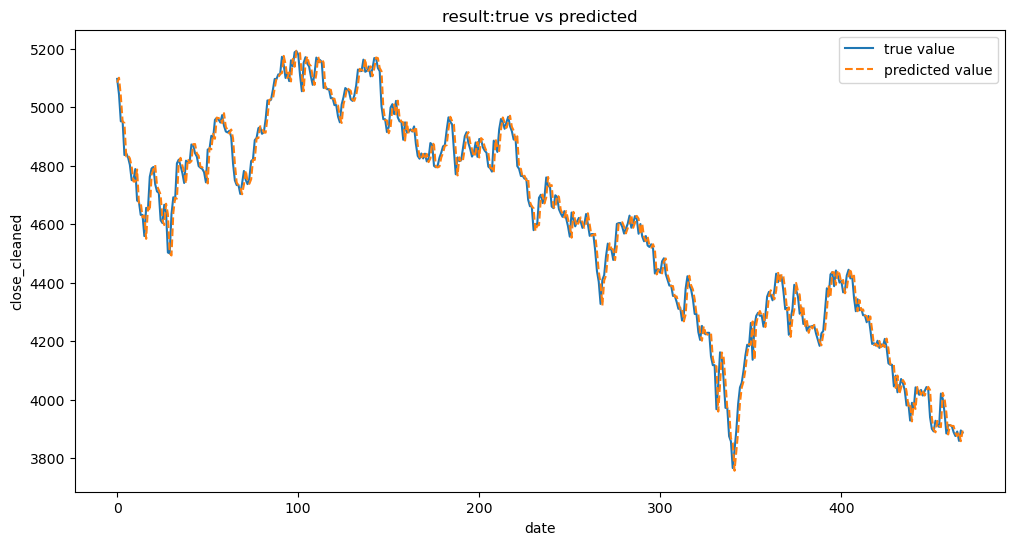

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test.index, test, label="true value")
plt.plot(test.index, predictions, label="predicted value", linestyle="--")
plt.xlabel("date")
plt.ylabel("close_cleaned")
plt.title("result:true vs predicted")
plt.legend()
plt.show()

## result:true vs predicted

The graph displayed is a comparison between the true values and predicted values of a financial time series, likely representing the closing prices of a stock. This kind of visualization is crucial for evaluating the performance of predictive models in finance.

### Analysis of the Graph

**Plot Description**:
- The solid line (orange) represents the actual historical data ("true value") of the stock's closing prices.
- The dashed line (blue) shows the predicted values from a model over the same time period.

**Key Observations**:
1. **Tracking Performance**: Both lines follow a very similar trajectory throughout the series, suggesting that the model has effectively captured the general trends and fluctuations in the stock price data.
2. **Prediction Accuracy**: The close alignment of the predicted values with the true values indicates high predictive accuracy. This suggests that the model is well-tuned and robust, capable of capturing the essential dynamics of the dataset.
3. **Divergence Points**: There are slight deviations between the predicted and actual values at certain points (e.g., around the peaks and troughs). These deviations could be areas where the model might struggle with extreme values or rapid changes in the stock price.

### Implications

- **Model Validation**: The graph serves as a validation tool, providing clear visual evidence that the model performs well in predicting the closing prices based on historical data.
- **Improvement Areas**: The areas where predictions deviate from actual values might need further investigation. Model parameters could be adjusted, or additional features might be incorporated into the model to handle these discrepancies better.
- **Forecasting Use**: For practical applications, such as trading or investment strategy development, this model appears to be a reliable tool for forecasting future prices, given its overall accuracy depicted in the graph.

This type of plot is typically used to assess the fit of financial models and is essential for backtesting in quantitative finance, allowing analysts to refine their models based on empirical evidence.


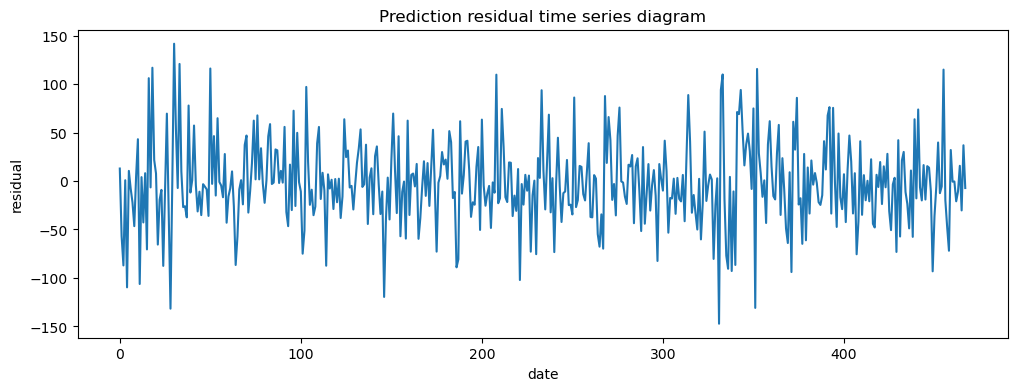

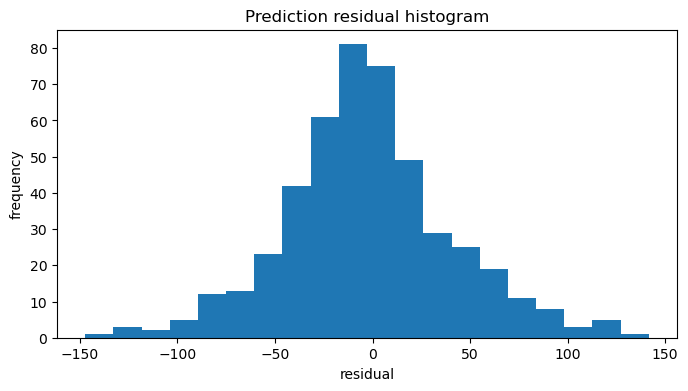

In [ ]:
residuals = test - predictions
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.xlabel("date")
plt.ylabel("residual")
plt.title("Prediction residual time series diagram")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=20)
plt.xlabel("residual")
plt.ylabel("frequency")
plt.title("Prediction residual histogram")
plt.show()

The provided images showcase two key diagnostic plots for assessing the performance of a predictive model: the Residual Time Series Diagram and the Prediction Residual Histogram. These plots are fundamental for evaluating how well a model fits the data and for identifying any systematic errors in the predictions.

## Residual Time Series Diagram

**Description and Analysis**:
- This plot displays the residuals, which are the differences between the actual values and the predicted values, over time.
- Ideally, residuals should appear as white noise, meaning they should have no discernible patterns or trends. In this plot, the residuals are fluctuating around zero without any apparent trend, suggesting that the model captures most of the systematic information in the data.
- However, the presence of significant spikes might indicate moments where the model fails to capture some influences or events affecting the data.

### Prediction Residual Histogram

**Description and Analysis**:
- The histogram shows the distribution of the residuals. A well-fitting model should ideally produce residuals that are normally distributed, centered around zero.
- The histogram appears approximately normally distributed, as indicated by its bell-shaped curve centered near zero, but there is some slight asymmetry with a tail extending towards the positive values.
- The presence of a few outliers in the tails of the distribution can suggest model inadequacies or the presence of extreme values in the data that the model did not predict accurately.

### Implications for Model Evaluation

1. **Model Adequacy**: The absence of a pattern in the time series plot and the approximate normal distribution of the histogram suggest that the model is generally adequate for the data, capturing the essential patterns without systematic bias.
   
2. **Further Diagnostics**:
   - Investigating the outliers or the spikes in the residuals could provide insights into specific instances where the model's predictions are less accurate.
   - Adjustments to the model, such as adding non-linear components or considering external factors not currently in the model, might help in reducing these residuals further.

3. **Model Improvement**:
   - Examining the residuals in conjunction with changes in the dataset or external events might help improve the model's robustness by incorporating additional variables or adjusting for anomalies.
   - Conducting further statistical tests on the residuals, like the Ljung-Box test for autocorrelation or the Shapiro-Wilk test for normality, would provide more formal measures of the residuals' properties.

These plots are crucial tools in the model diagnostic process, providing clear visual evidence to assess and refine predictive models, ensuring they are robust and reliable for forecasting or other analytical purposes.


In [ ]:
forecast = results.get_forecast(steps=5)
print(forecast.predicted_mean)

2340    3886.192426
2341    3885.701909
2342    3885.370975
2343    3884.991002
2344    3884.748033
Name: predicted_mean, dtype: float64


In [ ]:
forecast = results.get_forecast(steps=365)

predicted_mean = forecast.predicted_mean

future_dates = pd.date_range(start='2024-08-16', periods=365, freq='D')

predicted_mean.index = future_dates

conf_int = forecast.conf_int()
conf_int.index = future_dates

print("predicted mean:")
print(predicted_mean)
print("\n confidence interval:")
print(conf_int)

predicted mean:
2024-08-16    3886.192426
2024-08-17    3885.701909
2024-08-18    3885.370975
2024-08-19    3884.991002
2024-08-20    3884.748033
                 ...     
2025-08-11    3882.782032
2025-08-12    3882.782032
2025-08-13    3882.782032
2025-08-14    3882.782032
2025-08-15    3882.782032
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

 confidence interval:
            lower close_cleaned  upper close_cleaned
2024-08-16          3749.051632          4023.333220
2024-08-17          3688.020552          4083.383266
2024-08-18          3640.744597          4129.997353
2024-08-19          3598.919922          4171.062083
2024-08-20          3562.023158          4207.472908
...                         ...                  ...
2025-08-11           732.496106          7033.067957
2025-08-12           728.105148          7037.458915
2025-08-13           723.720294          7041.843769
2025-08-14           719.341518          7046.222545
2025-08-15           714.968794  